In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm

# Fonctions

## La fonction d'initialisation

\begin{align*}
\LARGE 
W^ { [c] } \in \mathbb{R} ^ {n ^ {[c]} ~ \times ~ n ^ {[c ~ - ~ 1]} } 
\end{align*}

\begin{align*}
\LARGE 
b^ { [c] } \in \mathbb{R} ^ {n ^ {[c]} ~ \times ~ 1}
\end{align*}

In [122]:
def initialisation(dimensions):
    
    parametres = {}
    
    c = len(dimensions)
    
    for c in range(1, c):
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c -1])
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)

    return parametres

## Teste de la fonction initialisation

In [123]:
parametres = initialisation([2, 32, 32, 2])
for key, val in parametres.items():
    print(key, val.shape)

W1 (32, 2)
b1 (32, 1)
W2 (32, 32)
b2 (32, 1)
W3 (2, 32)
b3 (2, 1)


## La fonction de propagation vers l'avant

\begin{align*}
\LARGE 
Z^ { [c] } = W ^ {[c] } . Y^ {[c ~ - ~ 1]} + b^ {[c] }
\end{align*}

\begin{align*}
\LARGE 
Y^ { [c] } =  \frac {1} {1 + e ^ {-Z ^ {[c] } }}
\end{align*}

In [124]:
def forward_propagation(X, parametres):
    
    activations = {'A0' : X}
    
    C = len(parametres) // 2
    
    for c in range(1, C + 1):
        Z = parametres['W' + str(c)].dot(activations['A' + str(c - 1)]) + parametres['b' + str(c)]
        activations['A' + str(c)]  = 1 /(1 + np.exp(-Z))

    return activations

## Teste de la propagation vers l'avant

In [125]:
# initialisation des valeurs de X et y 
X, y = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=0)
X = X.T
y = y.reshape((1, y.shape[0]))

In [126]:
activations = forward_propagation(X, parametres)
for key, val in activations.items():
    print(key, val.shape) 

A0 (2, 100)
A1 (32, 100)
A2 (32, 100)
A3 (2, 100)


## Fonction de la rétro-propagation

\begin{align*}
\LARGE 
dZ^ { [c_{f} ]} = Y ^ {[c_{f} ]} - y
\end{align*}

\begin{align*}
\LARGE 
dW^ { [c]} = \frac {1} {m} \times dZ ^ {[c]} . Y ^ {[c -1]^{T}}
\end{align*}

\begin{align*}
\LARGE 
db^ { [c ]} = \frac {1} {m} \sum_{axe1} dZ ^ {[c]} 
\end{align*}

\begin{align*}
\LARGE 
dZ^ { [c - 1]} = W ^ {[c]^{T}} \times dZ^ { [c]} \times Y ^ {[c -1]} (1 - Y ^ {[c -1]})
\end{align*}

In [138]:
def back_propagation(y, parametres, activations):

    m = y.shape[1]
    C = len(parametres) // 2
    
    dZ = activations['A' + str(C)] - y
    gradients = {}
    
    for c in reversed(range(1, C + 1)):
        gradients['dW' + str(c)] = 1 / m * np.dot(dZ, activations['A' + str(c - 1)].T) 
        gradients['db' + str(c)] = 1 / m * np.sum(dZ, axis=1, keepdims = True)
        if c > 1:
            dZ = np.dot(parametres['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)])
 
    return gradients

## Teste de la rétro-propagation

In [140]:
grad = back_propagation(y, parametres, activations)

for key, val in grad.items():
    print(key, val.shape) 

dW3 (2, 32)
db3 (2, 1)
dW2 (32, 32)
db2 (32, 1)
dW1 (32, 2)
db1 (32, 1)


\begin{align*}
\LARGE 
W^ { [c]} = W^ {[c]} - \alpha \times dW ^ {[c]} 
\end{align*}

\begin{align*}
\LARGE 
b^ { [c]} = b^ {[c]} - \alpha \times db ^ {[c]} 
\end{align*}

In [146]:
def update(gradients, parametres, learning_rate):

    C = len(parametres) // 2
    
    for c in range(1, C + 1):
        parametres['W' + str(c)] = parametres['W' + str(c)] - learning_rate * gradients['dW' + str(c)]
        parametres['b' + str(c)] = parametres['b' + str(c)] - learning_rate * gradients['db' + str(c)]
    return parametres

In [147]:
def predict(X, parametres):
    activations = forward_propagation(X, parametres)
    C = len(parametres) // 2
    Af = activations['A' + str(C)]
    return Af >= 0.5

In [155]:
def neural_network(X, y, hidden_layers = (32, 32, 32), learning_rate = 0.1, n_iter = 1000):
    
    np.random.seed(0)
    # initialisation parametres
    dimensions = list(hidden_layers)
    dimensions.insert(0, X.shape[0])
    dimensions.append(y.shape[0])
    parametres = initialisation(dimensions)

    train_loss = []
    train_acc = []

    # gradient descent
    for i in tqdm(range(n_iter)):
        
        activations = forward_propagation(X, parametres)
        gradients = back_propagation(y, parametres, activations)
        parametres = update(gradients, parametres, learning_rate)
    
        if i %10 == 0 :
            C = len(parametres) // 2
        
            # Analyse des courbes d'apprentissage
            train_loss.append(log_loss(y, activations['A' + str(C)]))
            y_pred = predict(X, parametres)
            current_accuracy = accuracy_score(y.flatten(), y_pred.flatten())
            train_acc.append(current_accuracy)

    #Visualisation des résultats
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
    ax[0].plot(train_loss, label= 'train_loss')
    ax[0].legend()
    
    ax[1].plot(train_acc, label= 'train_acc')
    ax[1].legend()
    
  #  visualisation(X, y, parametres, ax)

    ax[2].scatter(X[0, :], X[1, :], c=y, cmap='summer')
    plt.show()

    return parametres

# Dataset

dimensions de X: (2, 100)
dimensions de y: (1, 100)


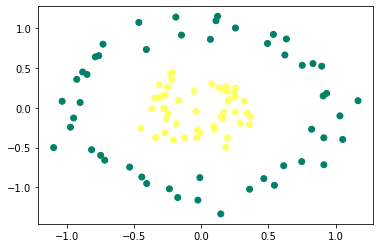

In [144]:
X, y = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=0)
X = X.T
y = y.reshape((1, y.shape[0]))

print('dimensions de X:', X.shape)
print('dimensions de y:', y.shape)

plt.scatter(X[0, :], X[1, :], c=y, cmap='summer')
plt.show()

In [133]:
X 

array([[-0.94957536,  0.09138459,  0.93214973,  0.20734231, -0.36750218,
         0.2532073 , -0.40867925, -0.27450909,  0.24224991,  0.158872  ,
         0.17984262,  0.19490678, -0.18640787,  0.12157863,  0.49287043,
        -0.81607272, -0.88256159, -0.90136274, -0.44207091,  0.63318667,
         0.74738819,  0.07947606,  0.83076047, -0.28699936,  0.91209859,
         1.05235514,  0.62194713,  0.35809164, -0.03880452, -0.16849662,
         0.18452538, -0.33911143,  0.10167817, -0.24980872,  0.3198604 ,
        -0.97315797, -0.73097704,  0.25473331, -0.21290872, -0.27834832,
         1.16614005,  0.19060984,  0.54409779,  0.35966887,  0.89607094,
        -0.1892848 , -0.46440441,  0.46542725, -0.02494581,  0.75084969,
        -0.02786858, -0.05339409,  0.90718408, -0.40622936, -0.74854102,
         0.36512093,  0.10964665, -0.17507169, -0.92614192,  0.25215638,
         0.2540514 , -0.71813367, -0.21920932,  0.20066063, -0.45295043,
        -0.26890899, -0.53262577, -0.12304334, -0.1

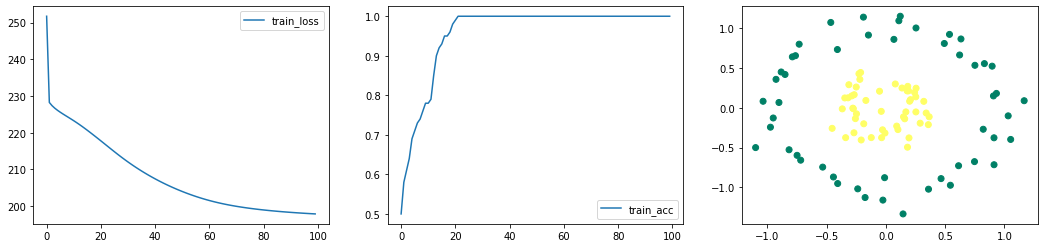

{'W1': array([[ 1.81769058,  0.48641301],
        [ 1.23854714,  1.97607369],
        [ 2.41536964, -1.36089636],
        [ 0.7232829 , -0.44679784],
        [-0.22550461,  1.2898364 ],
        [-0.03428699,  1.56389879],
        [ 1.31954647, -0.06193554],
        [-0.4081929 ,  0.4620787 ],
        [ 2.2642667 , -0.36059596],
        [ 0.52789804, -1.41998815],
        [-2.75202436,  0.54246999],
        [ 1.17895459, -0.89855528],
        [ 2.51122124, -1.60134548],
        [ 0.20005794,  0.30584036],
        [ 1.72207311,  1.75438163],
        [ 0.60011246,  0.78271297],
        [-1.02629484, -1.97146415],
        [-0.90333154,  0.35033362],
        [ 1.76974102,  1.13323525],
        [-0.5297186 , -0.42666132],
        [-1.11348528, -1.76118023],
        [-1.74594485,  2.13337561],
        [-0.0655784 , -0.17770286],
        [-1.44435835,  1.13105741],
        [-1.1282039 , -0.32320097],
        [-0.92115319, -0.02479613],
        [-0.35638325, -1.8246707 ],
        [-0.18219544, 

In [156]:
neural_network(X, y)